In this notebook, we will build a 3D map of a scene from a small set of images and refine it with the featuremetric optimization. We then localize an image downloaded from the Internet and show the effect of the refinement.

# Setup
We start by defining some output paths: where the intermediate files will be stored.

In [1]:
%load_ext autoreload
%autoreload 2
import tqdm, tqdm.notebook
tqdm.tqdm = tqdm.notebook.tqdm  # notebook-friendly progress bars
import os
import time
import sys
from hloc import extract_features, match_features, reconstruction, pairs_from_exhaustive, visualization
from hloc.visualization import plot_images, read_image
from hloc.utils.viz_3d import init_figure, plot_points, plot_reconstruction, plot_camera_colmap
from pixsfm.util.visualize import init_image, plot_points2D
from pixsfm.refine_hloc import PixSfM
from pixsfm import ostream_redirect
from PIL import Image, ImageDraw
import pycolmap
from pathlib import Path
#import visualize_model
# redirect the C++ outputs to notebook cells
cpp_out = ostream_redirect(stderr=True, stdout=True)
cpp_out.__enter__()

In [2]:
import torch 
print(torch.__version__)
print(torch.cuda.get_arch_list())

1.9.1+cu111
['sm_37', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'sm_80', 'sm_86']


In [3]:
images = Path('datasets/monarch/')
outputs = Path('outputs/monarch-demo/')
!rm -rf $outputs
sfm_pairs = outputs / 'pairs-sfm.txt'
loc_pairs = outputs / 'pairs-loc.txt'
features = outputs / 'features.h5'
matches = outputs / 'matches.h5'
raw_dir = outputs / "raw"
ref_dir = outputs / "ref"
''' model location in case of intrinsics locked '''
ref_dir_locked = outputs / "ref_locked"
''' model location in case of intrinsics not locked '''
ref_dir_not_locked = outputs / "ref_dir_not_locked" 

Here we will use SuperPoint local features with the SuperGlue matcher, but it's easy to switch to other features like SIFT or R2D2.

In [4]:
feature_conf = extract_features.confs['superpoint_aachen']
matcher_conf = match_features.confs['superglue']

# 3D mapping and refinement
First we list the images used for mapping. These are all day-time shots of Sacre Coeur.

In [5]:
# '''masking of the tractor hood from the images '''
# ''' output => datasets/monarch/{target_folder}/image_name.jpg '''
# def draw_box_around_tractor_hood(image_path, target_folder): 
#     image = Image.open(image_path)
#     w, h = image.size
#     box_x1, box_y1 = 460, 770  # Top-left corner
#     box_x2, box_y2 = 1630, 1080  # Bottom-right corner
#     outline_color = (0, 0, 0)  # Red in RGB format
#     fill_color = (0, 0, 0)  # Black in RGB format
#     draw = ImageDraw.Draw(image)
#     draw.rectangle([box_x1, box_y1, box_x2, box_y2], outline=outline_color, fill=fill_color)
#     directory_path,filename = os.path.split(image_path)
#     parent_directory_path = os.path.dirname(directory_path)
#     target_directory = os.path.join(parent_directory_path, target_folder)
#     os.makedirs(target_directory, exist_ok = True)
#     target_image_path = os.path.join(target_directory,filename)
#     image.save(target_image_path)
#     return target_image_path 

In [6]:
references_left = [str(p.relative_to(images)) for i, p in enumerate((images / 'left/').iterdir())]
references_right = [str(p.relative_to(images)) for i, p in enumerate((images / 'right/').iterdir())]

In [7]:
print(len(references_left))

582


In [8]:
references_left = sorted(references_left, key=lambda x: int(x.split('/')[-1].split('.')[0]))
references_right = sorted(references_right, key=lambda x: int(x.split('/')[-1].split('.')[0]))

In [9]:
print(len(references_left))

582


In [10]:
references_left = references_left[40:82] 
references_right = references_right[40:82]
references = references_left + references_right

In [11]:
'''sorting references so that each stereo pair is together in the list '''
references = sorted(references, key=lambda x: int(x.split('/')[-1].split('.')[0]))

In [12]:
print(references)

['left/40.jpg', 'right/40.jpg', 'left/41.jpg', 'right/41.jpg', 'left/42.jpg', 'right/42.jpg', 'left/43.jpg', 'right/43.jpg', 'left/44.jpg', 'right/44.jpg', 'left/45.jpg', 'right/45.jpg', 'left/46.jpg', 'right/46.jpg', 'left/47.jpg', 'right/47.jpg', 'left/48.jpg', 'right/48.jpg', 'left/49.jpg', 'right/49.jpg', 'left/50.jpg', 'right/50.jpg', 'left/51.jpg', 'right/51.jpg', 'left/52.jpg', 'right/52.jpg', 'left/53.jpg', 'right/53.jpg', 'left/54.jpg', 'right/54.jpg', 'left/55.jpg', 'right/55.jpg', 'left/56.jpg', 'right/56.jpg', 'left/57.jpg', 'right/57.jpg', 'left/58.jpg', 'right/58.jpg', 'left/59.jpg', 'right/59.jpg', 'left/60.jpg', 'right/60.jpg', 'left/61.jpg', 'right/61.jpg', 'left/62.jpg', 'right/62.jpg', 'left/63.jpg', 'right/63.jpg', 'left/64.jpg', 'right/64.jpg', 'left/65.jpg', 'right/65.jpg', 'left/66.jpg', 'right/66.jpg', 'left/67.jpg', 'right/67.jpg', 'left/68.jpg', 'right/68.jpg', 'left/69.jpg', 'right/69.jpg', 'left/70.jpg', 'right/70.jpg', 'left/71.jpg', 'right/71.jpg', 'left/7

In [13]:
# ''' masking the tractor hood in all the images'''
# ''' returns list of path to the masked images '''
# start_time = time.time()
# target_folder = "masked_images"
# masked_references = [draw_box_around_tractor_hood(p, target_folder) for p in references]
# end_time = time.time()
# elapsed_time = end_time - start_time

# target_path = os.path.join(images, target_folder)

# ''' sorting masked_references sequentially '''
# ''' smf => sorted masked references '''
# #smf = sorted(masked_references, key = lambda x: int(((x.split("/")[-1]).split(".")[0]).split("_")[0]))

# print(f"type(masked_references): {type(masked_references)}")


In [14]:
# smf = []
# for i in range(0, len(references)//2 - 1): 
#     left  = "masked_images/" + str(i) + "_left.jpg"
#     right = "masked_images/" + str(i) + "_right.jpg"
#     smf.append(left)
#     smf.append(right)

In [15]:
# print(f"smf: {smf}")
# print(f"len(smf) : {len(smf)}")

In [16]:
print(references)

['left/40.jpg', 'right/40.jpg', 'left/41.jpg', 'right/41.jpg', 'left/42.jpg', 'right/42.jpg', 'left/43.jpg', 'right/43.jpg', 'left/44.jpg', 'right/44.jpg', 'left/45.jpg', 'right/45.jpg', 'left/46.jpg', 'right/46.jpg', 'left/47.jpg', 'right/47.jpg', 'left/48.jpg', 'right/48.jpg', 'left/49.jpg', 'right/49.jpg', 'left/50.jpg', 'right/50.jpg', 'left/51.jpg', 'right/51.jpg', 'left/52.jpg', 'right/52.jpg', 'left/53.jpg', 'right/53.jpg', 'left/54.jpg', 'right/54.jpg', 'left/55.jpg', 'right/55.jpg', 'left/56.jpg', 'right/56.jpg', 'left/57.jpg', 'right/57.jpg', 'left/58.jpg', 'right/58.jpg', 'left/59.jpg', 'right/59.jpg', 'left/60.jpg', 'right/60.jpg', 'left/61.jpg', 'right/61.jpg', 'left/62.jpg', 'right/62.jpg', 'left/63.jpg', 'right/63.jpg', 'left/64.jpg', 'right/64.jpg', 'left/65.jpg', 'right/65.jpg', 'left/66.jpg', 'right/66.jpg', 'left/67.jpg', 'right/67.jpg', 'left/68.jpg', 'right/68.jpg', 'left/69.jpg', 'right/69.jpg', 'left/70.jpg', 'right/70.jpg', 'left/71.jpg', 'right/71.jpg', 'left/7

In [17]:
references[59]

'right/69.jpg'

In [18]:
features_path_ = extract_features.main(feature_conf, images, image_list= references, feature_path=features)
#match_features.main(matcher_conf, sfm_pairs, features=features, matches=matches);

[2024/02/29 02:54:26 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 3},
 'output': 'feats-superpoint-n4096-r1024',
 'preprocessing': {'grayscale': True, 'resize_max': 1024}}


Loaded SuperPoint model


  0%|          | 0/84 [00:00<?, ?it/s]

[2024/02/29 02:54:31 hloc INFO] Finished exporting features.


In [19]:
from hloc.extract_features import list_h5_names
h5_feature_names = list_h5_names(features_path_)
print(f"len(h5_feature_names): {len(h5_feature_names)}")
print(h5_feature_names[:10])

len(h5_feature_names): 84
['left/54.jpg', 'left/78.jpg', 'right/50.jpg', 'right/76.jpg', 'right/64.jpg', 'right/74.jpg', 'right/69.jpg', 'right/47.jpg', 'left/72.jpg', 'right/54.jpg']


Then we extract features and match them across image pairs. Since we deal with few images, we simply match all pairs exhaustively.

In [20]:
# features_path_ = extract_features.main(feature_conf, images, image_list=references_final, feature_path=features)
# #match_features.main(matcher_conf, sfm_pairs, features=features, matches=matches);

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
current_path:  /home/skumar/pixel-perfect-sfm
<class 'str'>


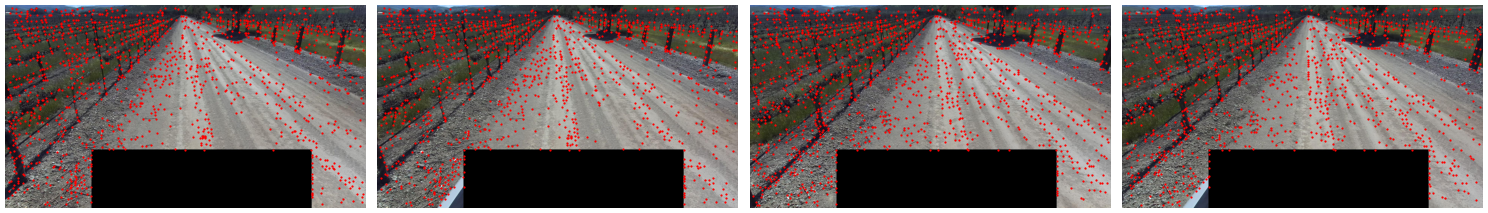

In [21]:
from hloc.utils.viz import plot_keypoints, save_plot
from hloc.utils.io import get_keypoints
import matplotlib.pyplot as plt
import numpy as np
import os

ref_trim_ = references[:4]
plot_images([read_image(images / r) for r in ref_trim_], dpi=50, figsize=4.2)

kps_list_ = [] 
for r in ref_trim_:
    kps = get_keypoints(features_path_, r)
    print(type(kps))
    kps_list_.append(kps)
    
plot_keypoints(kps_list_, colors = "red",  ps = 10)

current_path_ = os.getcwd()

print("current_path: ", current_path_)

print(type(current_path_))

final_path = current_path_ + "/kps.png"


save_plot(final_path)


In [22]:
import collections.abc as collections
isinstance(references, collections.Iterable)

True

In [23]:
pairs_from_exhaustive.stereo_main(sfm_pairs, image_list=references)

[2024/02/29 02:54:36 hloc INFO] Found 326 pairs.


In [24]:
#print("features: ", features)
#print("matches: ", matches)
match_features.main(matcher_conf, sfm_pairs, features=features, matches=matches);

[2024/02/29 02:54:38 hloc INFO] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}


Loaded SuperGlue model ("outdoor" weights)


  0%|          | 0/326 [00:00<?, ?it/s]

[2024/02/29 02:55:07 hloc INFO] Finished exporting matches.


In [25]:
match_names = list_h5_names(matches)
for name in match_names: 
    if "right-52.jpg" in name: 
        print (name)

right-52.jpg/right-51.jpg
left-54.jpg/right-52.jpg
left-53.jpg/right-52.jpg
right-54.jpg/right-52.jpg
right-53.jpg/right-52.jpg
right-52.jpg/left-51.jpg
right-52.jpg/left-52.jpg
right-52.jpg/right-50.jpg


features: outputs/monarch-demo/features.h5
kp1.shape: (1351, 2)
m.shape: (996, 2)


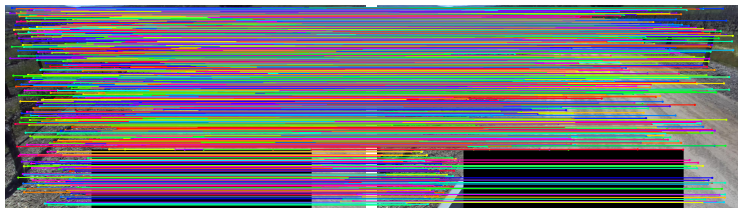

In [26]:
''' script to plot matches between two frames'''
from hloc.utils.viz import plot_matches
from hloc.utils.io import get_matches, get_keypoints
#img1 = images.joinpath(references[0])
#img2 = images.joinpath(references[1])

#print(f"img1 : {img1.as_posix()} img_2: {img2.as_posix()}")

print(f"features: {features}")
kp1 = get_keypoints(features, references[0])
kp2 = get_keypoints(features, references[1])
print(f"kp1.shape: {kp1.shape}")

m, _ = get_matches(matches, references[0], references[1])
print(f"m.shape: {m.shape}")

m1 = np.array([kp1[i] for i in m[:,0]])
m2 = np.array([kp2[i] for i in m[:, 1]])

#print(m1[:10])

plot_images([read_image(images / r) for r in references[:2]], dpi=50, figsize=4.2)
#plot_matches(kp1.transpose, kp2.transpose)
#plot_matches(kp1.transpose, kp2.transpose)
plot_matches(m1, m2)
#plot_matches(m[:,0], m[:,1])
#print(m[:10])
#kp1 = 
#matches, scores = 

Now we run the reconstruction with and without the featuremetric refinement. For this dataset, when computing the dense features, we resize the images such that they are not larger than 1024 pixels.

In [27]:
fx = 1093.2768
fy = 1093.2768
cx = 964.989
cy = 569.276
opencv_camera_params =','.join(map(str, (fx, fy, cx, cy, 0, 0, 0, 0)))

In [28]:
#sfm = PixSfM({"dense_features": {"max_edge": 1024}})


#conf1 = {"dense_features": {"max_edge": 1024}}

conf2 = {
    "BA": {"optimizer": {"refine_focal_length": False,"refine_extra_params": False, "refine_extrinsics": False}},
    "dense_features": {"max_edge":1024}
}

sfm = PixSfM(conf=conf2)



[2024/02/29 02:56:16 pixsfm.features.models.s2dnet INFO] Loading S2DNet checkpoint at /home/skumar/pixel-perfect-sfm/pixsfm/features/models/checkpoints/s2dnet_weights.pth.
[2024/02/29 02:56:16 pixsfm INFO] Loaded dense extractor with configuration:
{'cache_format': 'chunked',
 'device': 'auto',
 'dtype': 'half',
 'fast_image_load': False,
 'l2_normalize': True,
 'load_cache_on_init': False,
 'max_edge': 1024,
 'model': {'name': 's2dnet'},
 'overwrite_cache': False,
 'patch_size': 16,
 'pyr_scales': [1.0],
 'resize': 'LANCZOS',
 'sparse': True,
 'use_cache': False}


In [29]:
'''CASE 2 => INITIAL K IS PROVIDED + K IS LOCKED '''

image_options = dict(camera_model='OPENCV', 
                     camera_params=opencv_camera_params
                    )

mapper_options_one = dict(ba_refine_focal_length=False, 
                      ba_refine_extra_params=False,
                     ba_refine_principal_point=False)

mapper_options_two = dict(ba_refine_focal_length=False, 
                      ba_refine_extra_params=False,
                     ba_refine_principal_point=False)

hloc_args_not_locked = dict(image_list=references,
                image_options=image_options,
                camera_mode="PER_FOLDER",
                mapper_options=mapper_options_two)

#hloc_args_not_locked = dict(image_list=references)

K_locked, sfm_outputs_not_locked = sfm.reconstruction(ref_dir_locked, images, sfm_pairs, features, matches, **hloc_args_not_locked)


[2024/02/29 02:56:16 pixsfm INFO] Building matching graph...
[2024/02/29 02:56:16 pixsfm INFO] Extracting dense features...


  0%|          | 0/84 [00:00<?, ?it/s]

/home/skumar/e6/lib/python3.8/site-packages/torchvision/transforms/functional.py:165: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  img = torch.as_tensor(np.asarray(pic))


[2024/02/29 02:56:57 pixsfm INFO] Computing tracks...
[2024/02/29 02:56:57 pixsfm INFO] # graph nodes: 98213
[2024/02/29 02:56:57 pixsfm INFO] # graph edges: 154905
[2024/02/29 02:56:58 pixsfm INFO] # tracks: 24090
[2024/02/29 02:56:58 pixsfm INFO] Start feature-metric keypoint adjustment.


[2024/02/29 02:56:58 pixsfm WARNING] 38 / 1953 problems have more than 50 keypoints.
         Maximum keypoints in a problem: 84
100%[████████████████████] 98213/98213 [00:21, 4620.70it/s]


[2024/02/29 02:57:19 pixsfm INFO] KA Time: 21.2612s, cost change: 0.0208946 --> 0.0180002


[2024/02/29 02:57:19 hloc INFO] Creating an empty database...
[2024/02/29 02:57:19 hloc INFO] Importing images into the database...
[2024/02/29 02:57:20 hloc INFO] Importing features into the database...


  0%|          | 0/84 [00:00<?, ?it/s]

[2024/02/29 02:57:20 hloc INFO] Importing matches into the database...


  0%|          | 0/326 [00:00<?, ?it/s]

[2024/02/29 02:57:20 hloc INFO] Performing geometric verification of the matches...
[2024/02/29 02:57:23 hloc INFO] Running 3D reconstruction...
[2024/02/29 03:00:28 hloc INFO] Reconstructed 1 model(s).
[2024/02/29 03:00:28 hloc INFO] Largest model is #0 with 84 images.
[2024/02/29 03:00:28 hloc INFO] Reconstruction statistics:
Reconstruction:
	num_reg_images = 84
	num_cameras = 2
	num_points3D = 8180
	num_observations = 31641
	mean_track_length = 3.86809
	mean_observations_per_image = 376.679
	mean_reprojection_error = 1.13373
	num_input_images = 84


[2024/02/29 03:00:28 pixsfm INFO] Extracting references.


100%[████████████████████] 8180/8180 [00:00, 11190.1it/s]


[2024/02/29 03:00:29 pixsfm INFO] Reference Extraction Time: 0.737434s
[2024/02/29 03:00:29 pixsfm INFO] Start feature-reference bundle adjustment.


100%[████████████████████] 101/101 [00:08, 11.5534it/s]


[2024/02/29 03:00:38 pixsfm INFO] BA Time: 8.7447s, cost change: 0.0205246 --> 0.0202534
